# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

In [1]:
# install package for displaying animation
!pip install JSAnimation

# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

using device:  cpu


In [2]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



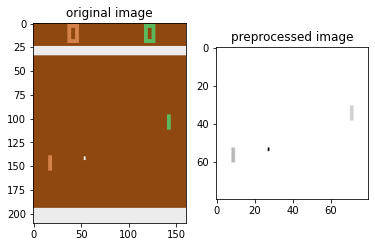

In [3]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()



# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F



# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
        
        # 80x80 to outputsize x outputsize
        # outputsize = (inputsize - kernel_size + stride)/stride 
        # (round up if not an integer)

        # output = 20x20 here
        self.conv = nn.Conv2d(2, 1, kernel_size=4, stride=4)
        self.size=1*20*20
        
        # 1 fully connected layer
        self.fc = nn.Linear(self.size, 1)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
    
        x = F.relu(self.conv(x))
        # flatten the tensor
        x = x.view(-1,self.size)
        return self.sig(self.fc(x))


# run your own policy!
# policy=Policy().to(device)
policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress


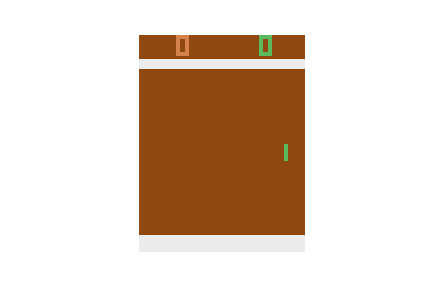
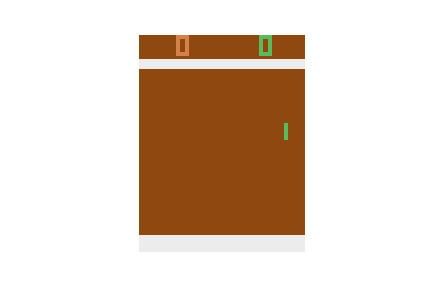
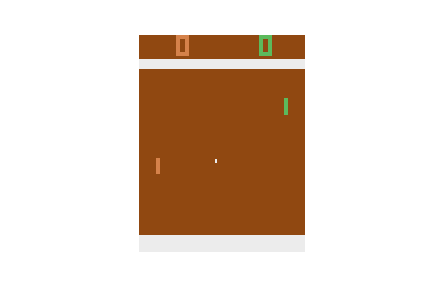
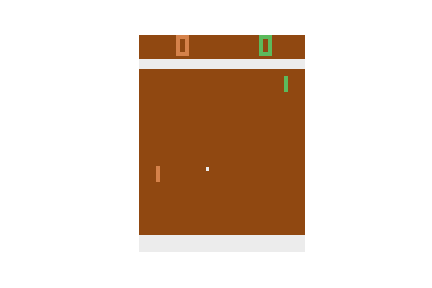
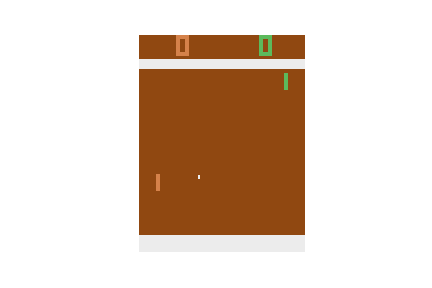
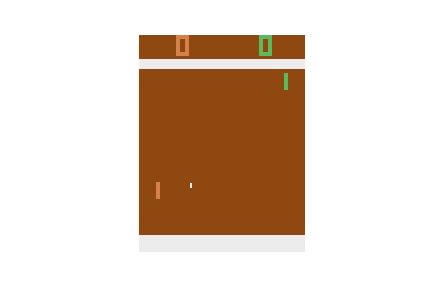
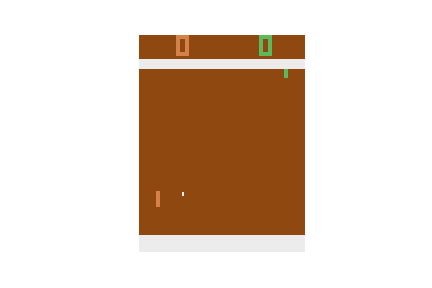
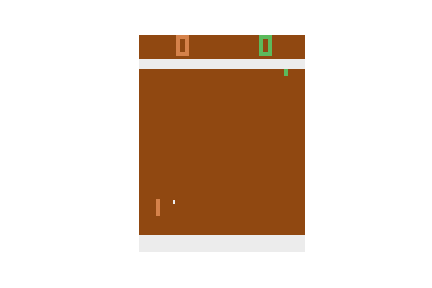
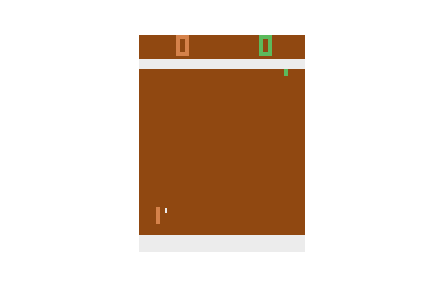
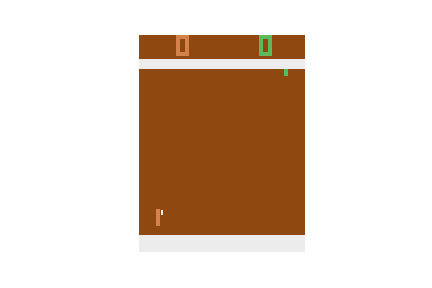
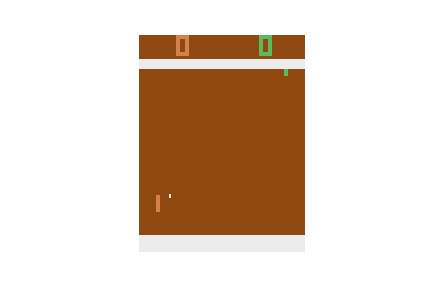
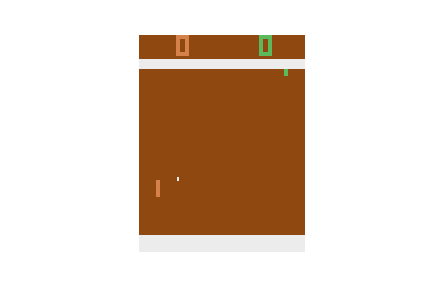
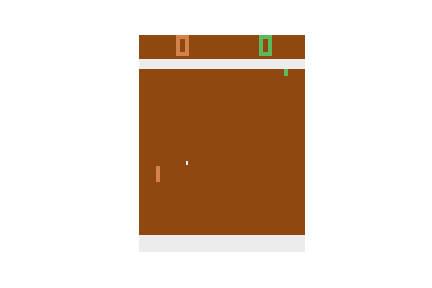
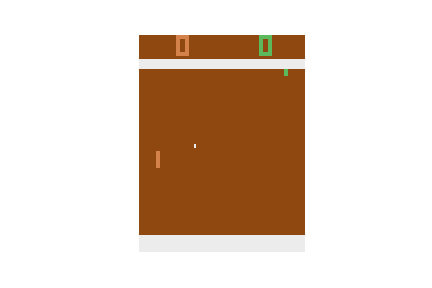
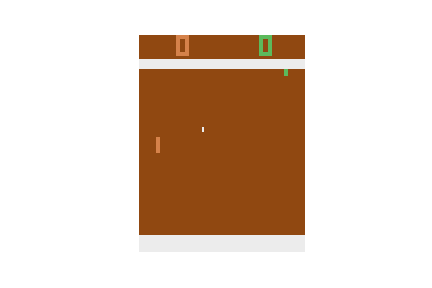
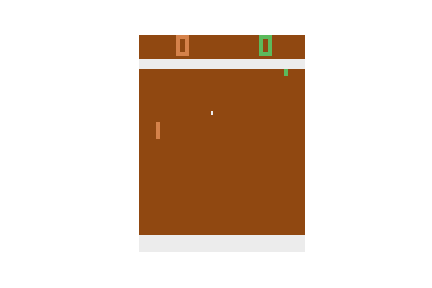
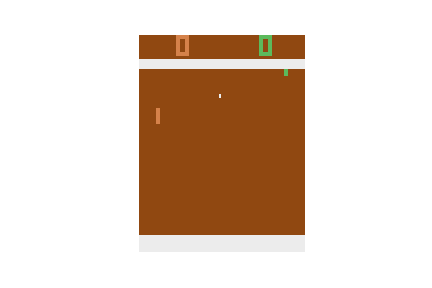
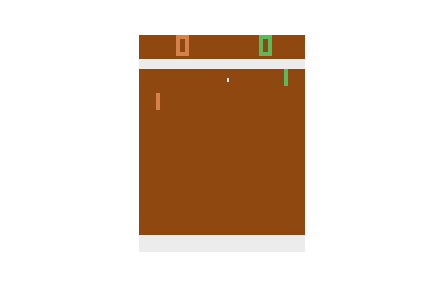
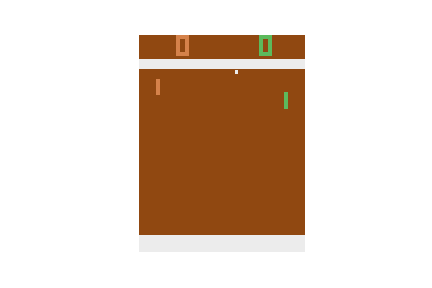
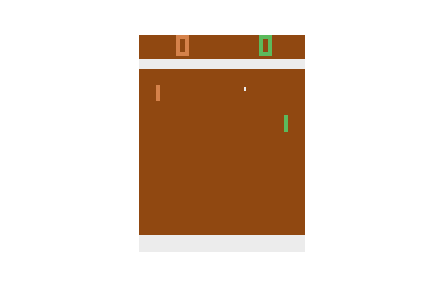
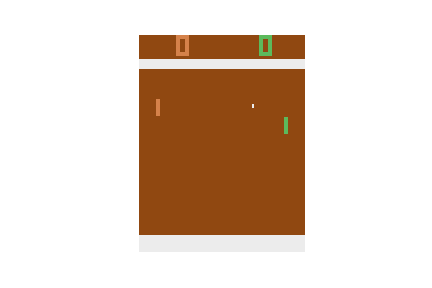
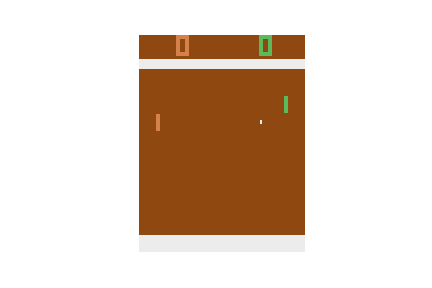
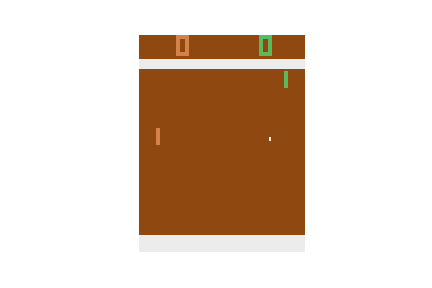
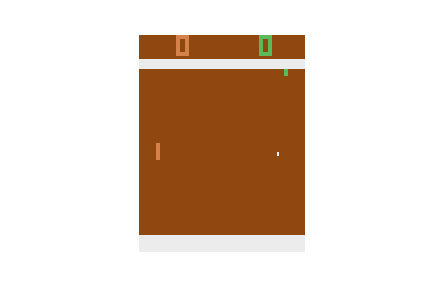
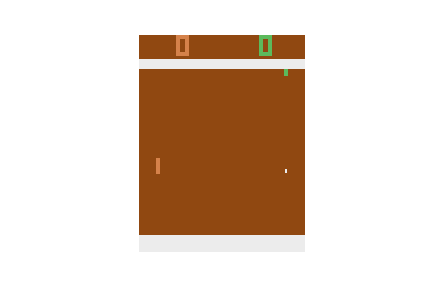
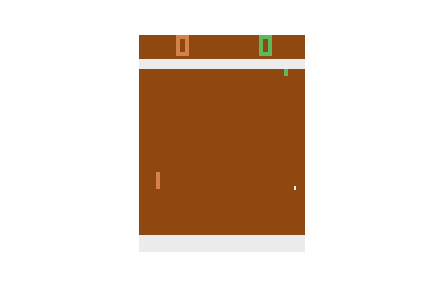
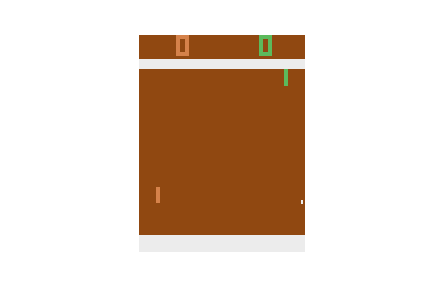
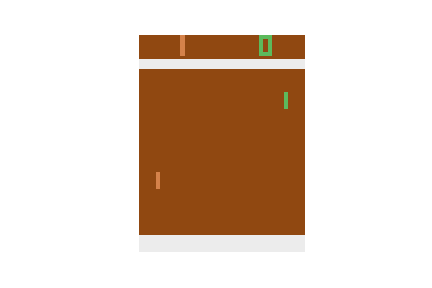
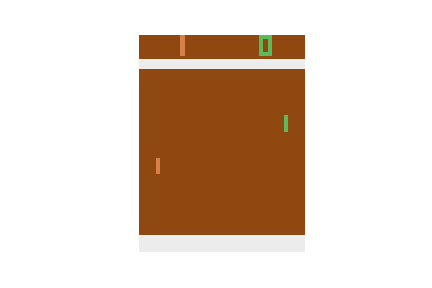
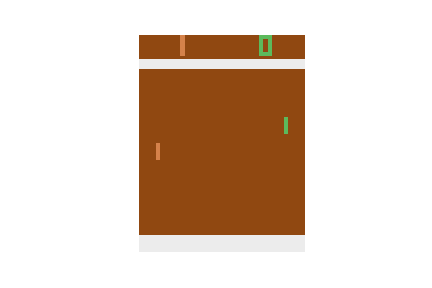
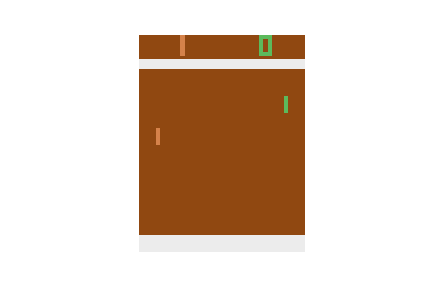
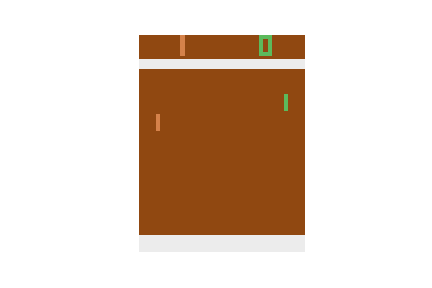
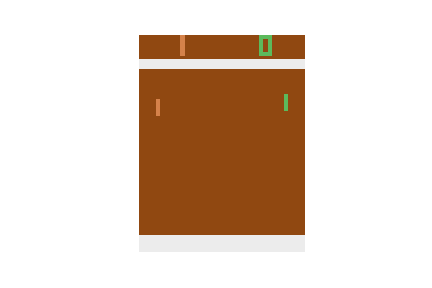
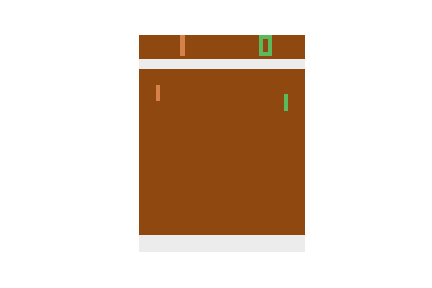
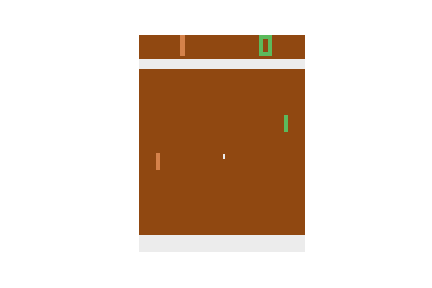
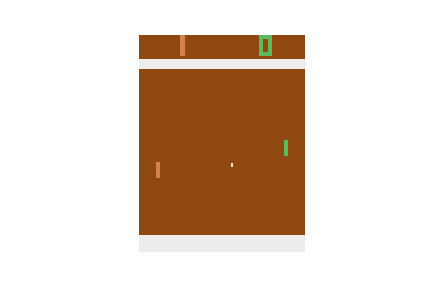
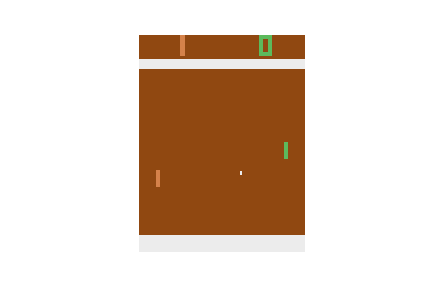
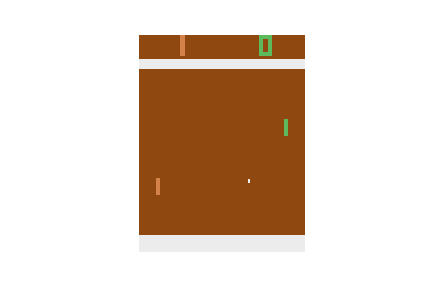
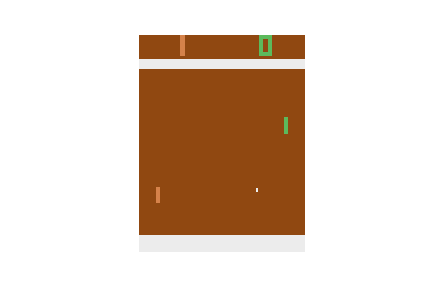
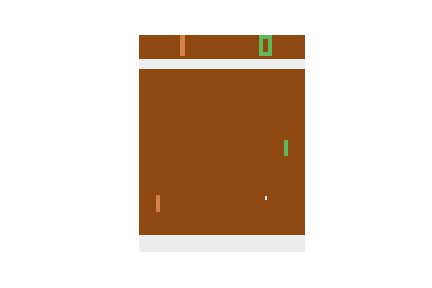
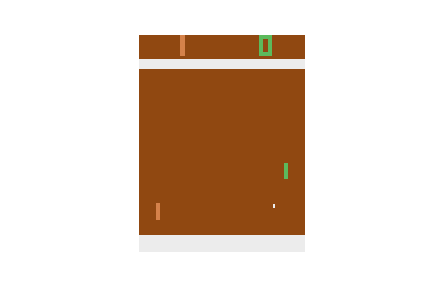
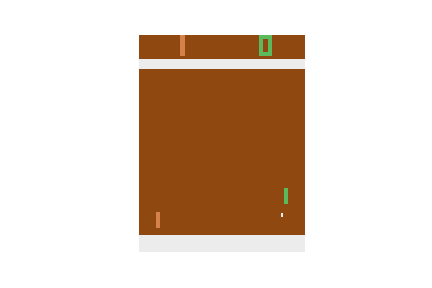
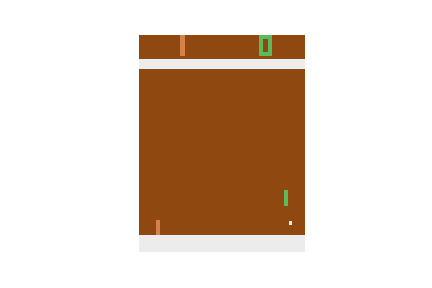
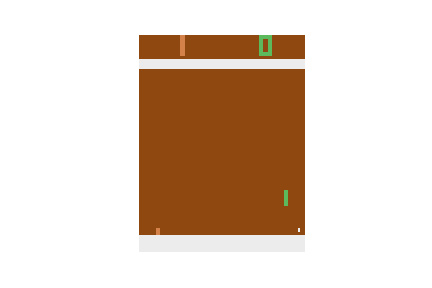
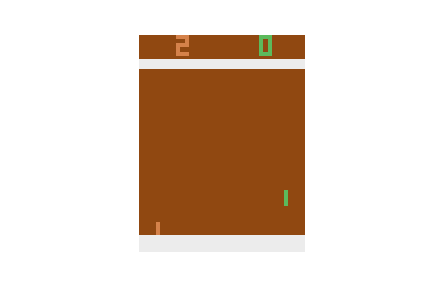
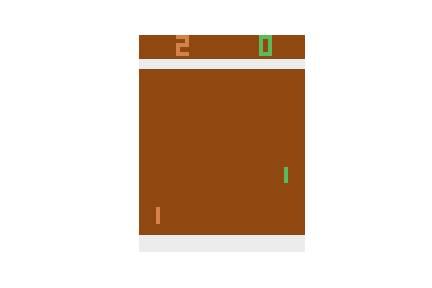
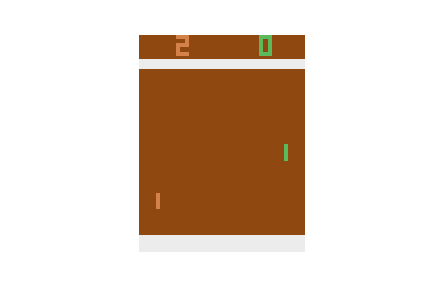
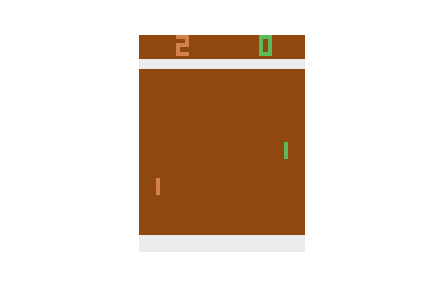
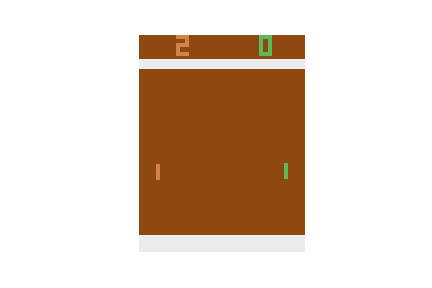
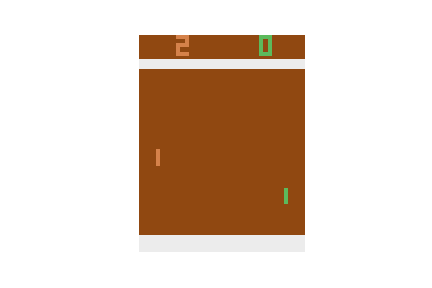
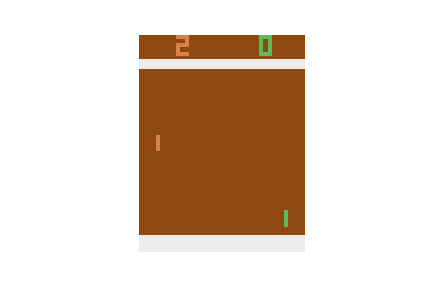
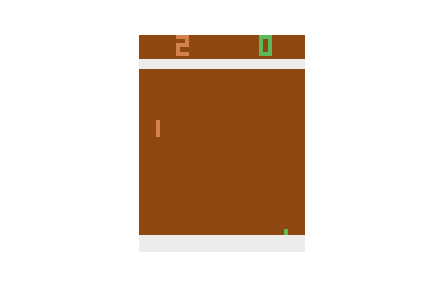
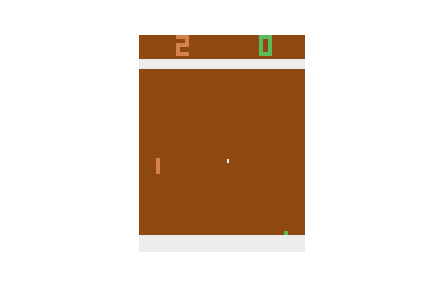
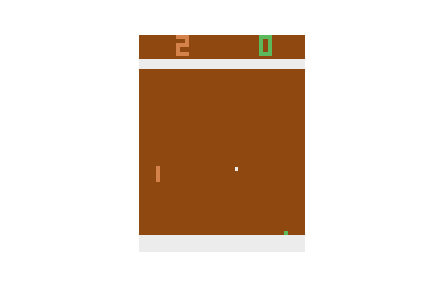
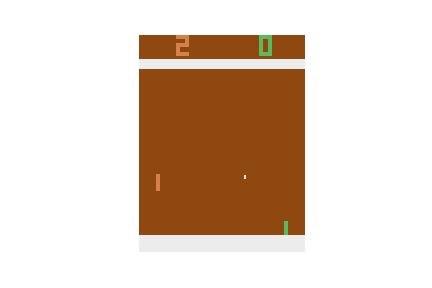
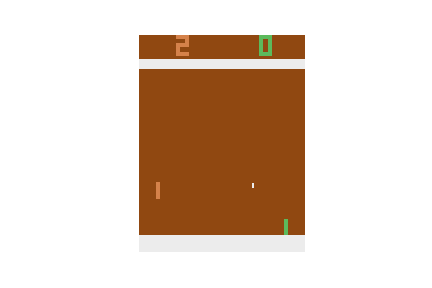
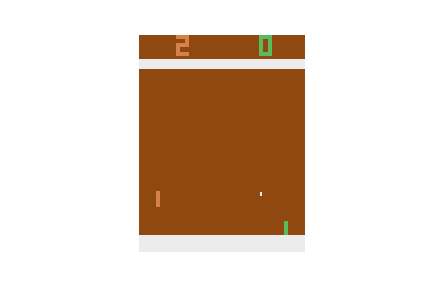
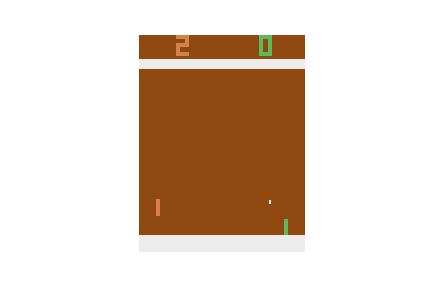
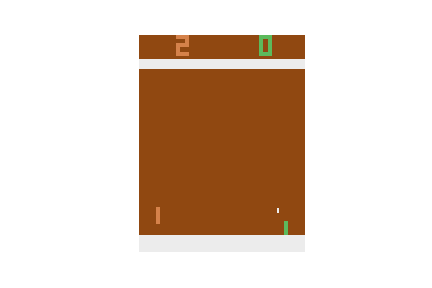
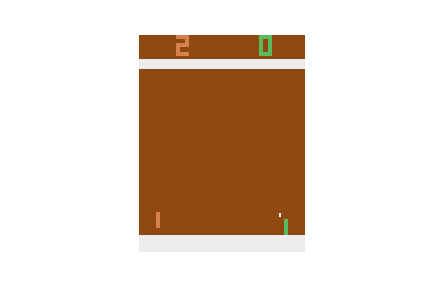
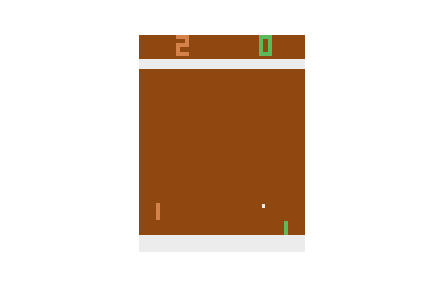
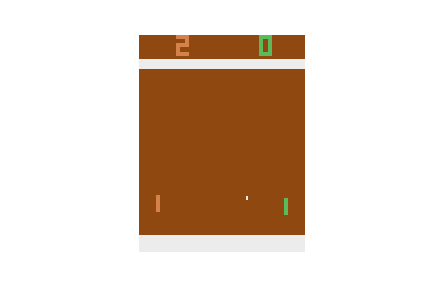
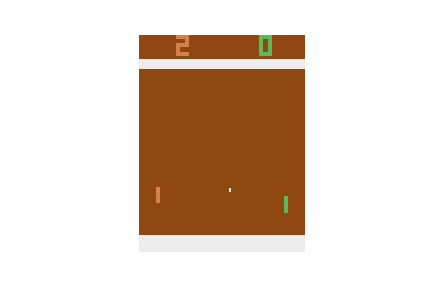
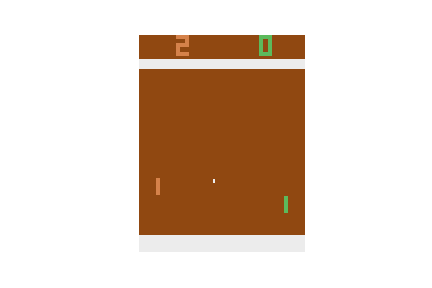
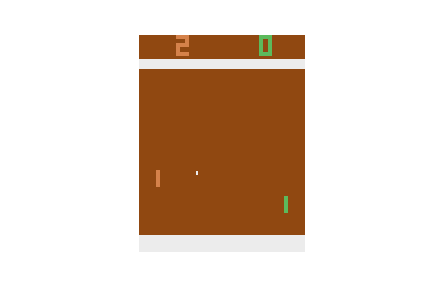
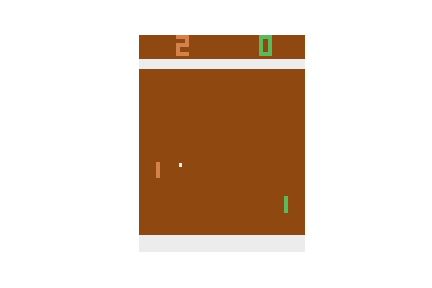
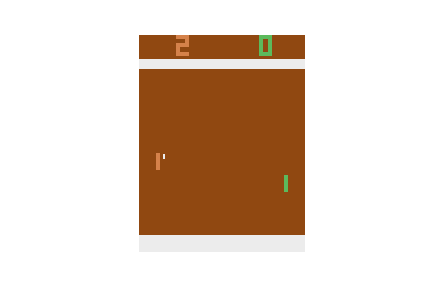
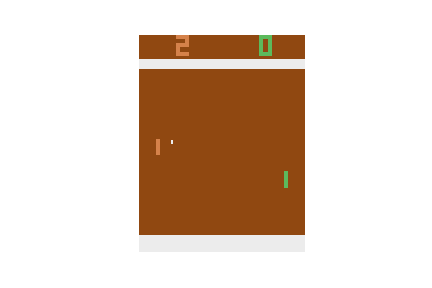
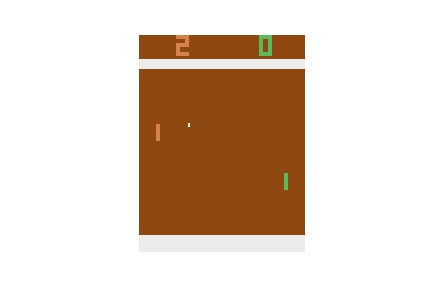
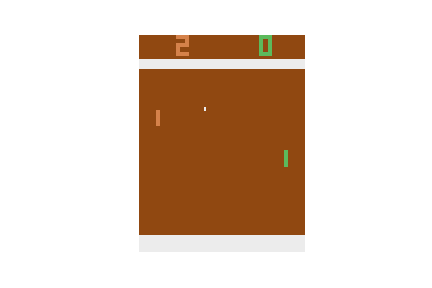
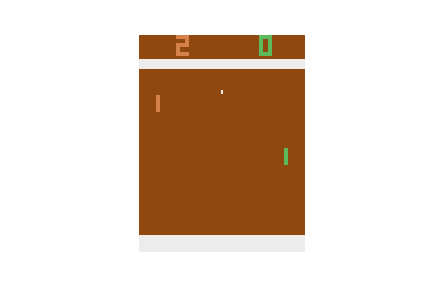
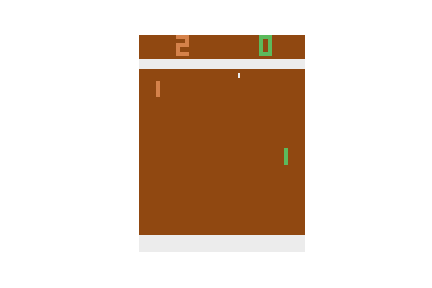
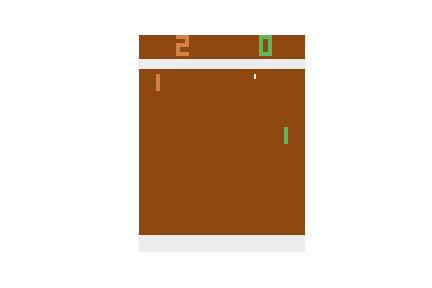
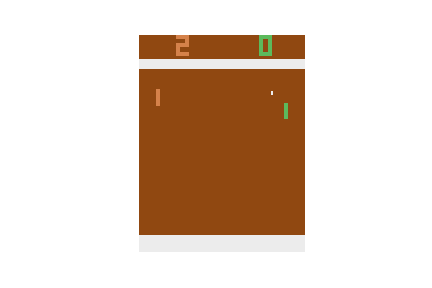
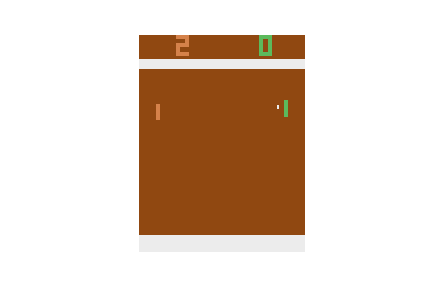
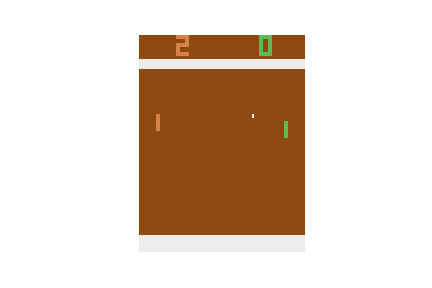
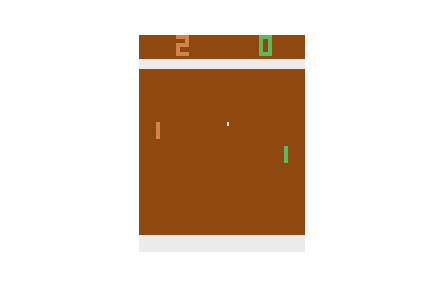
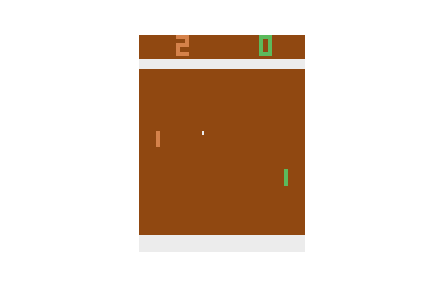
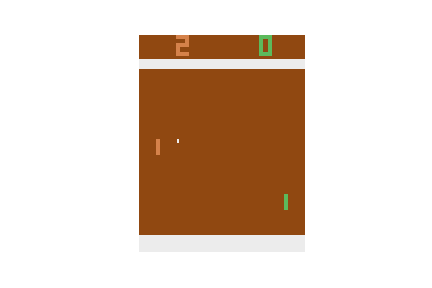
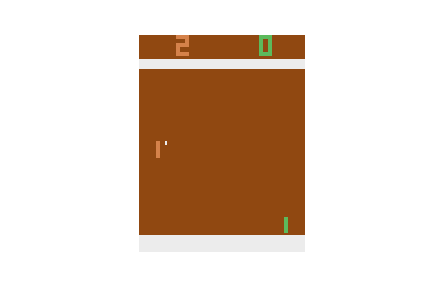
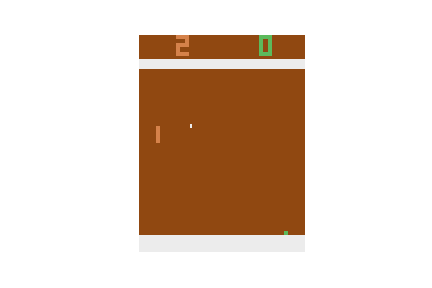
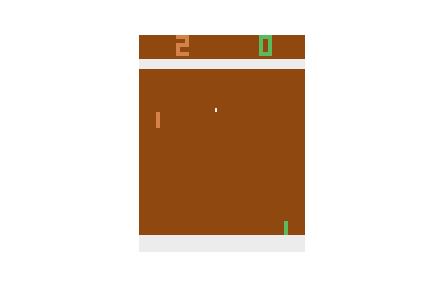
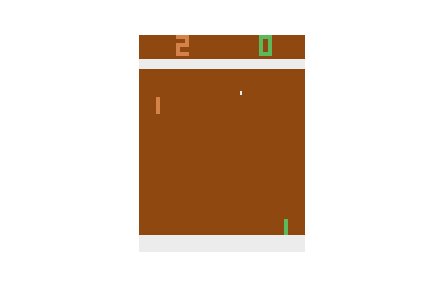
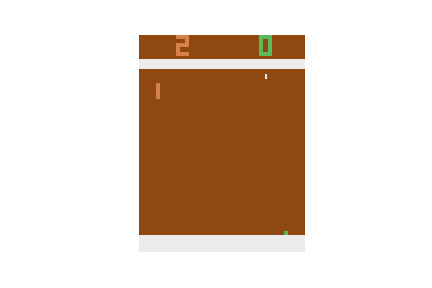
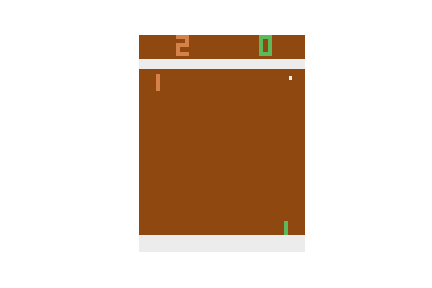
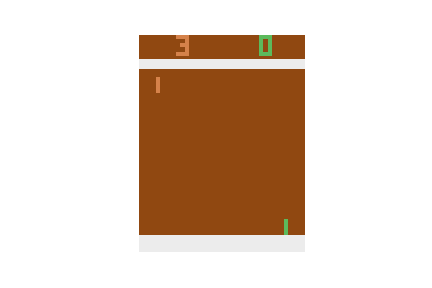
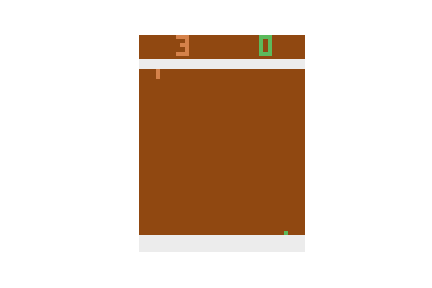
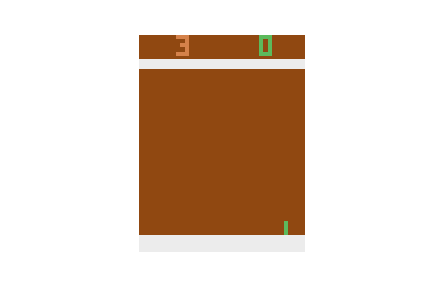
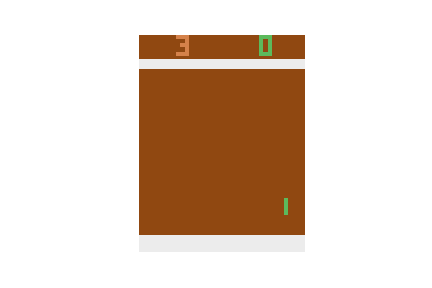
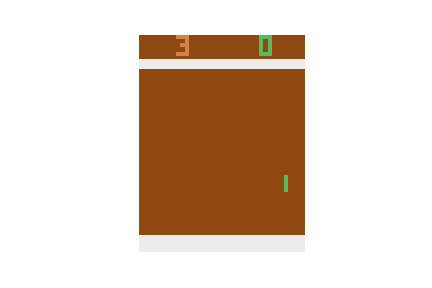
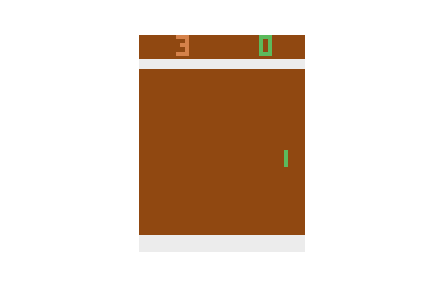
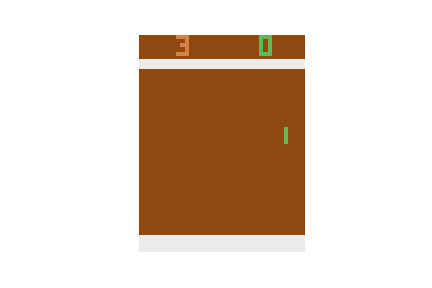
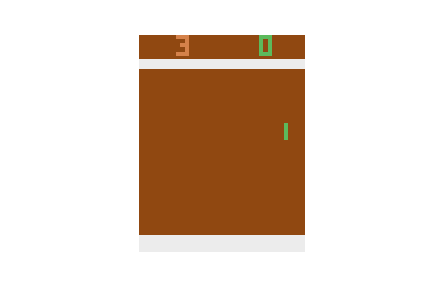
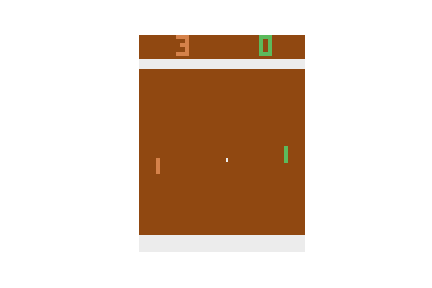
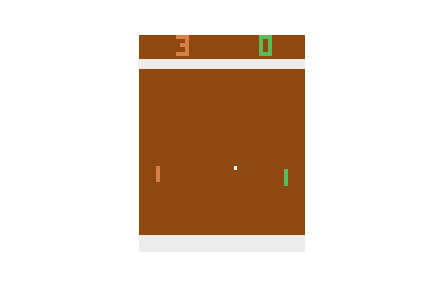
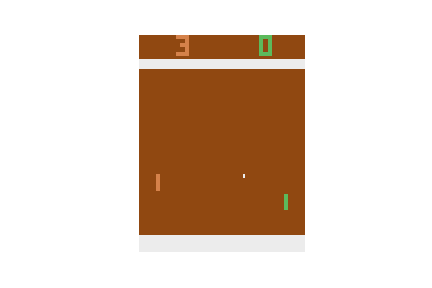
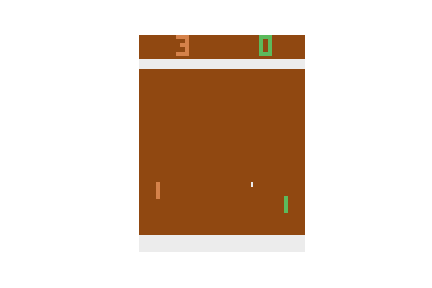
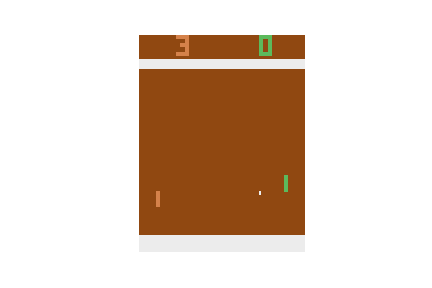
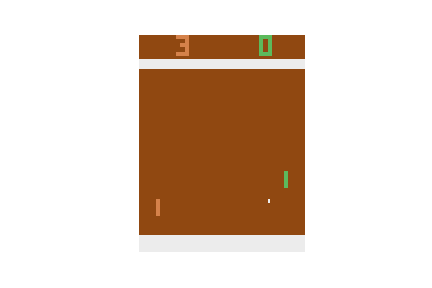
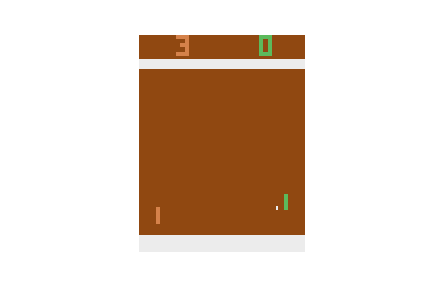
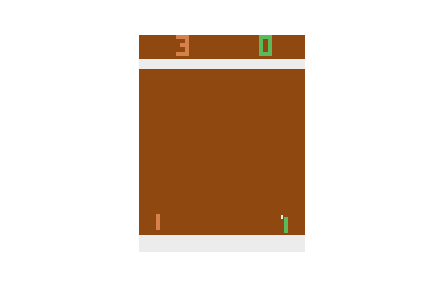
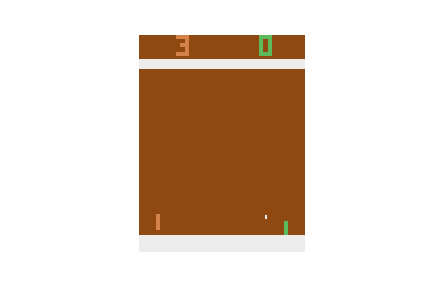
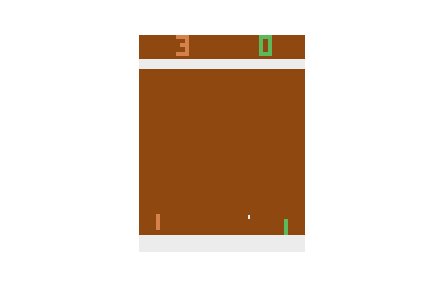
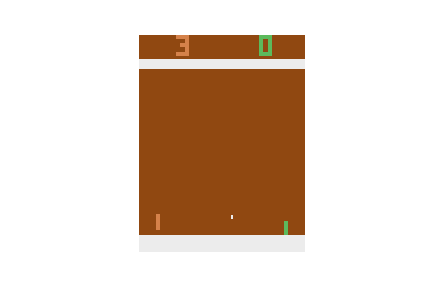
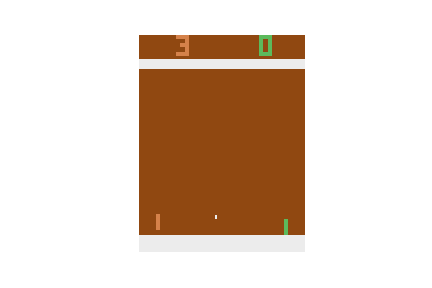
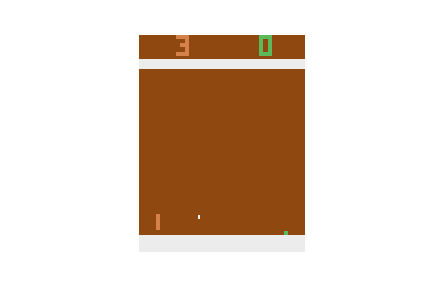
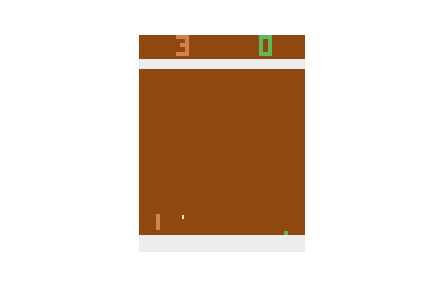
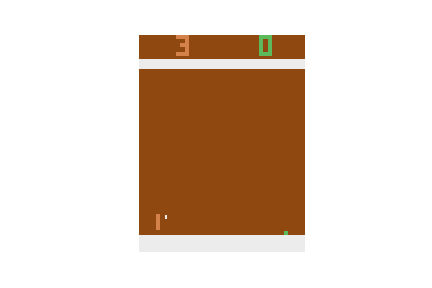
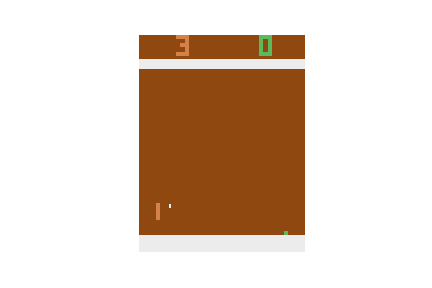
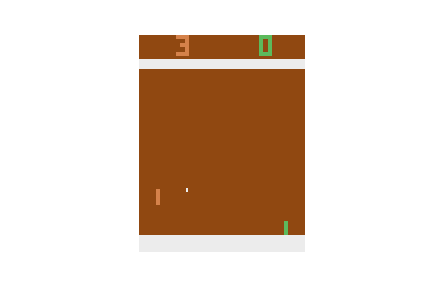
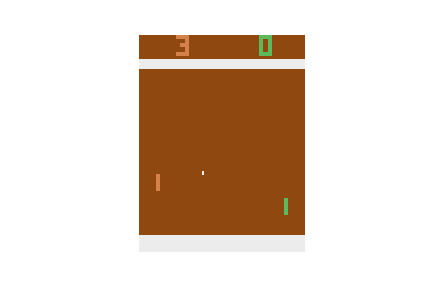
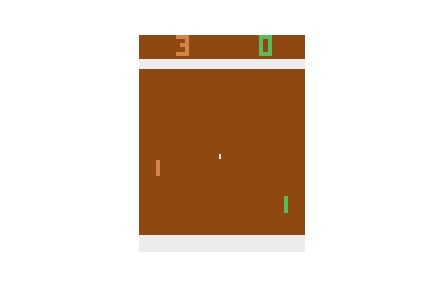
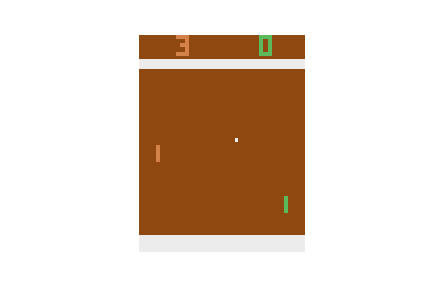
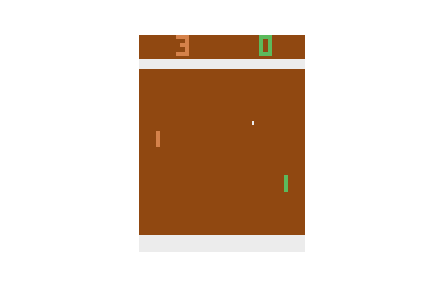
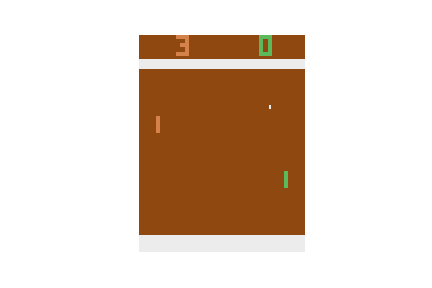
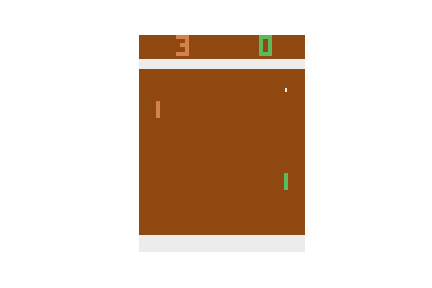
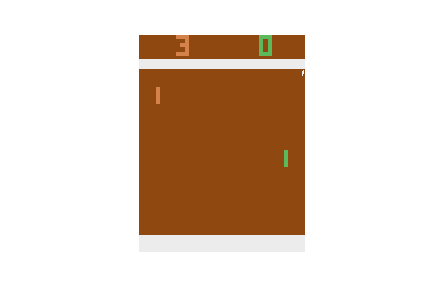
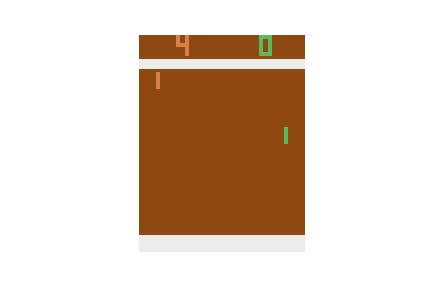
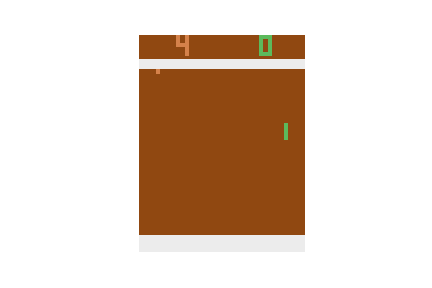
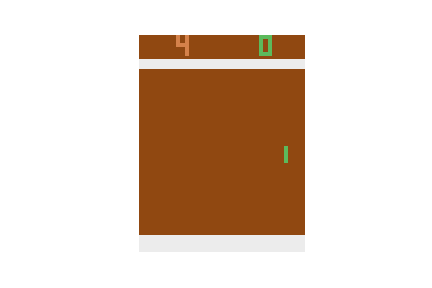
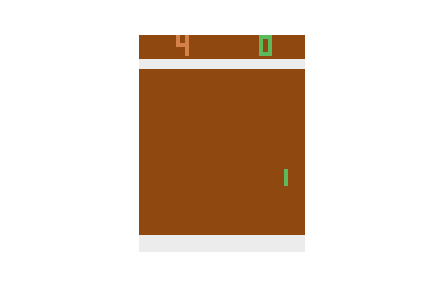
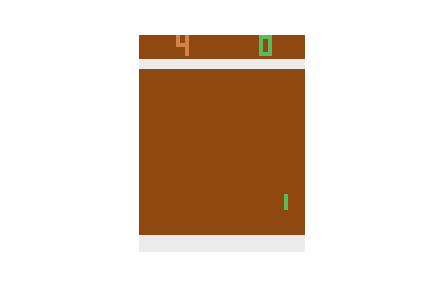
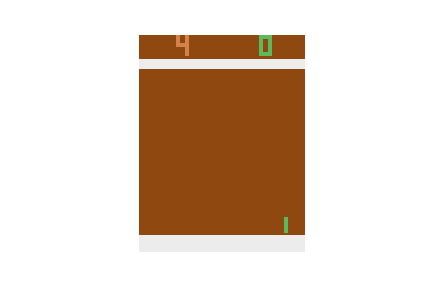
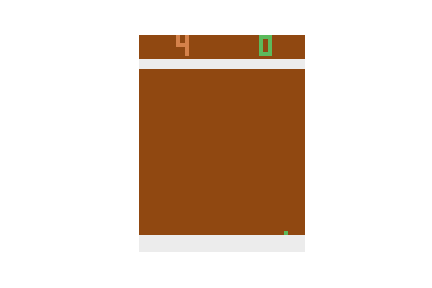
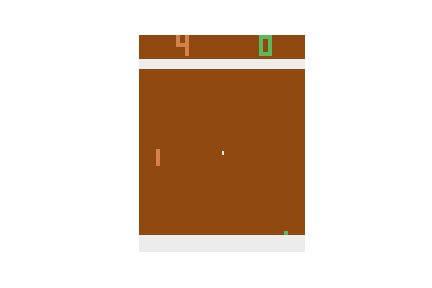
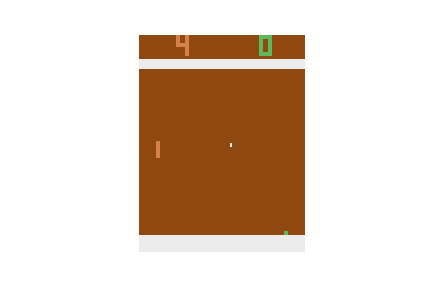
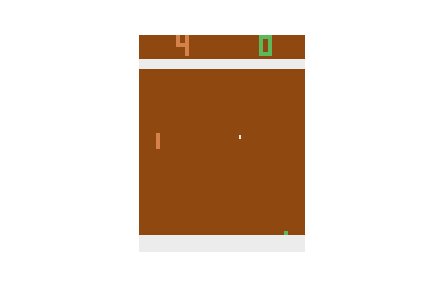
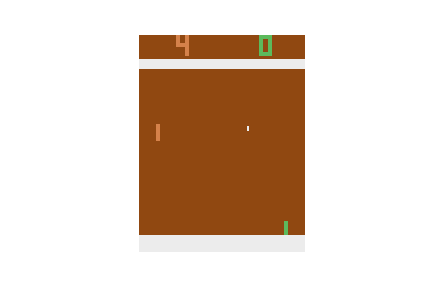
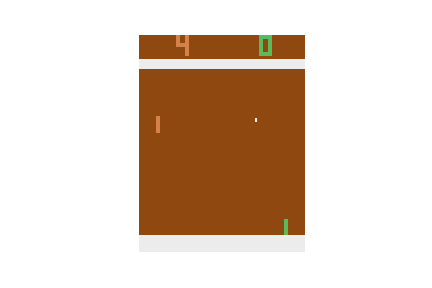
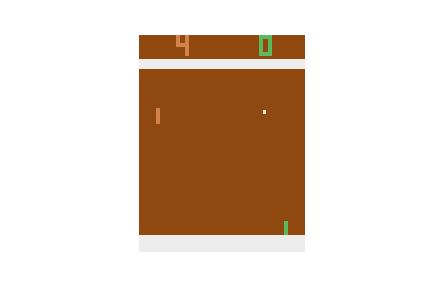
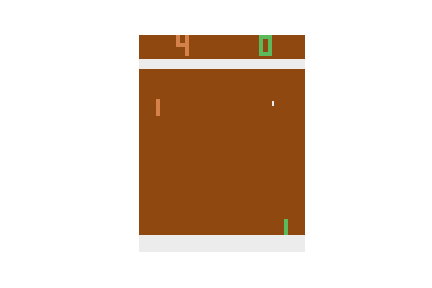
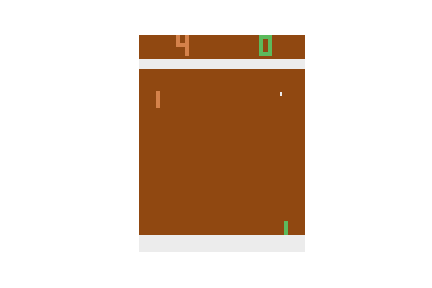
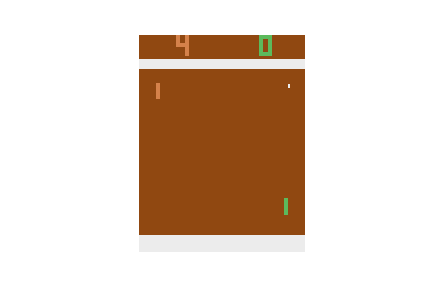
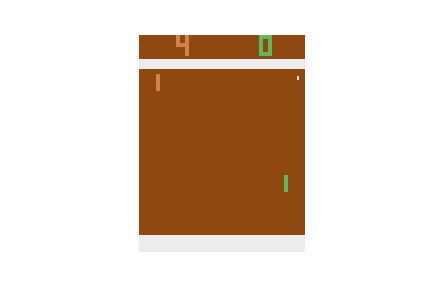
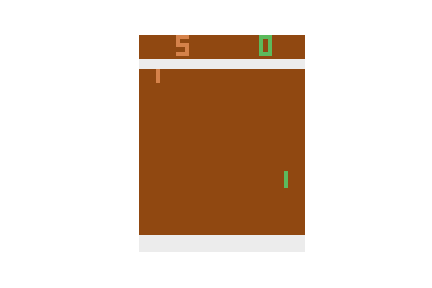
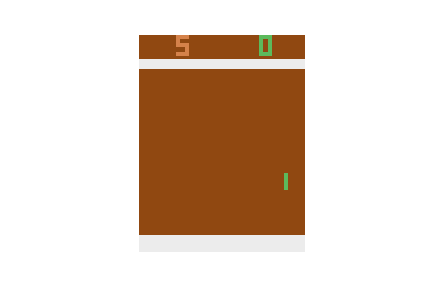
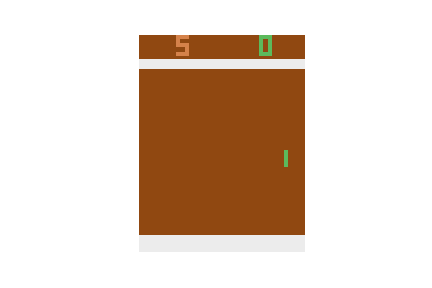
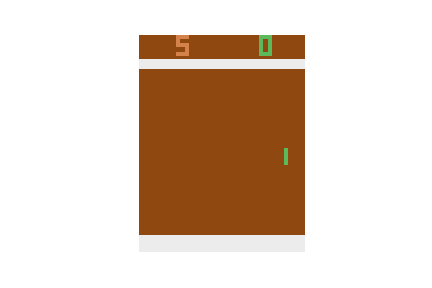
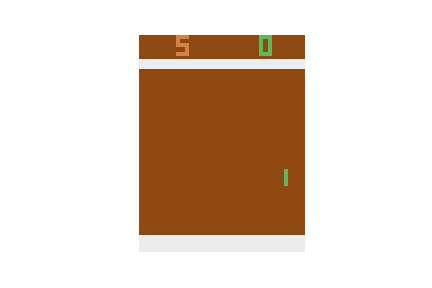
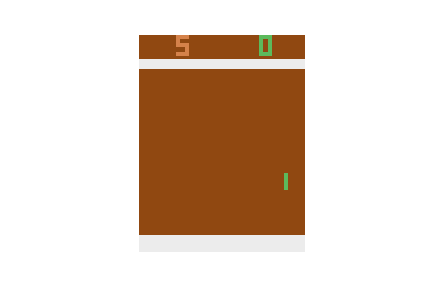
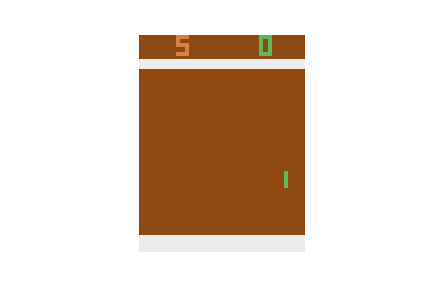
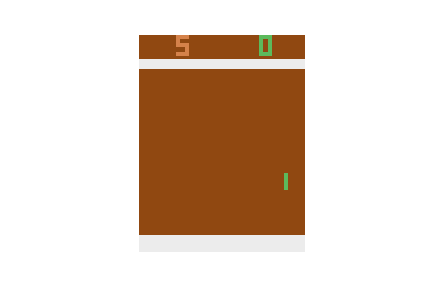
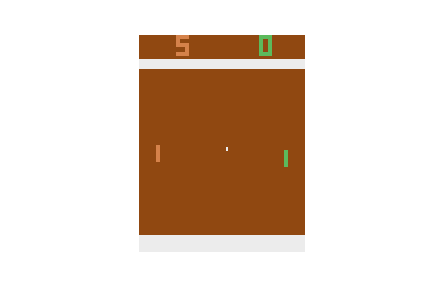
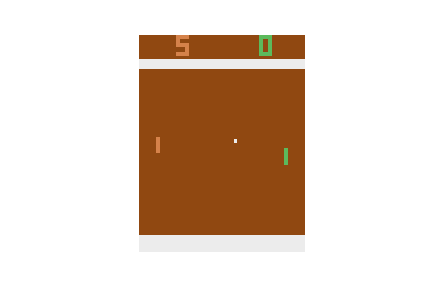
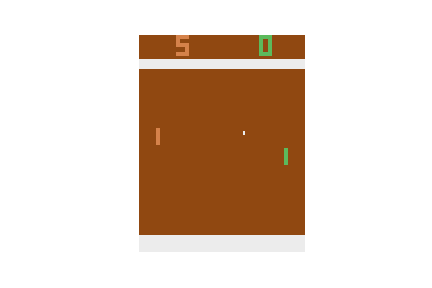
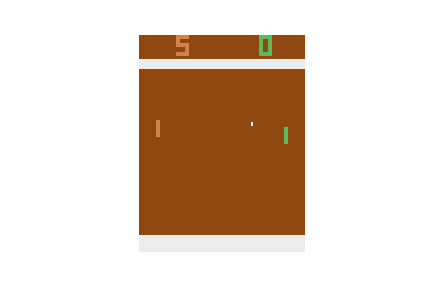
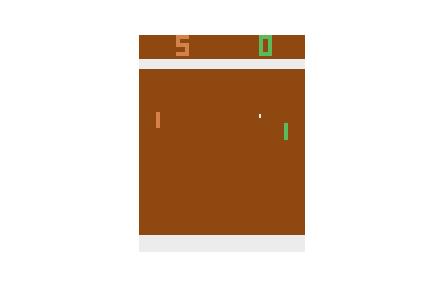
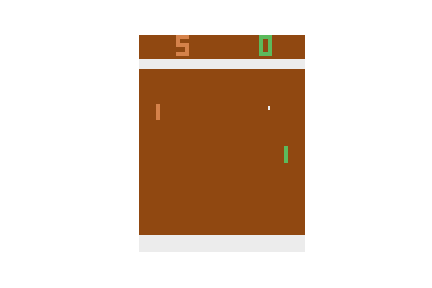
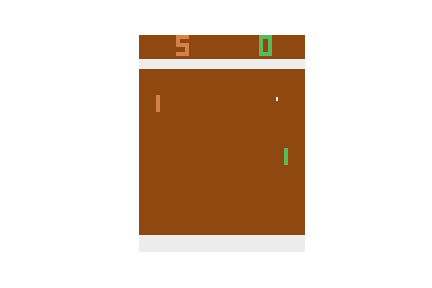
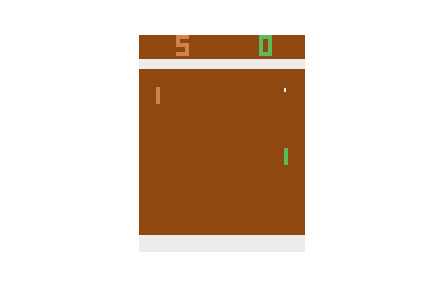
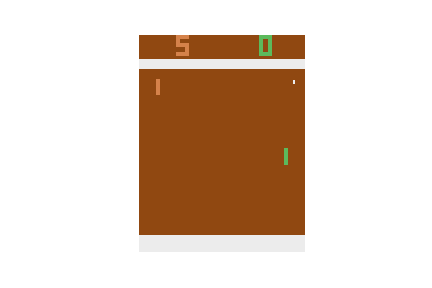
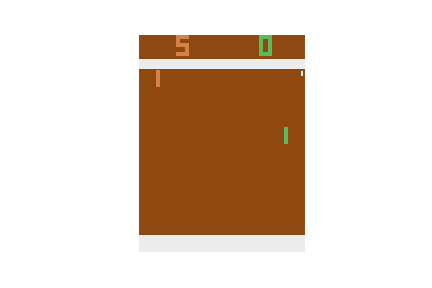
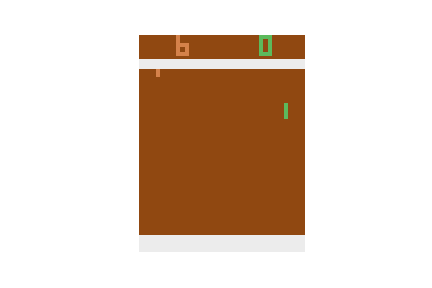
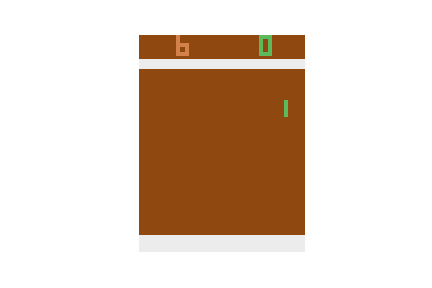
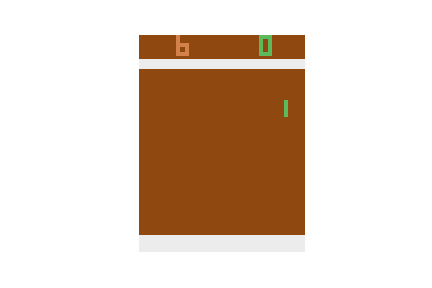
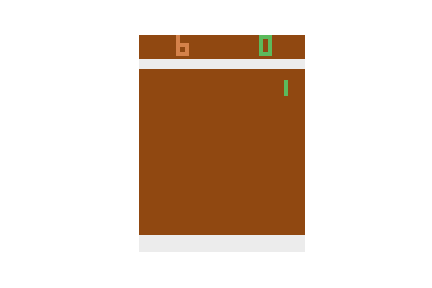
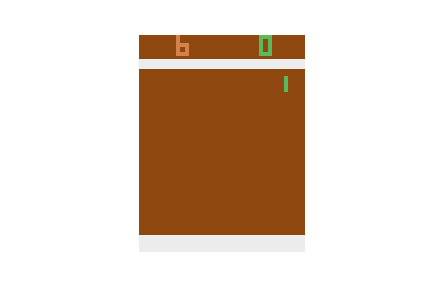
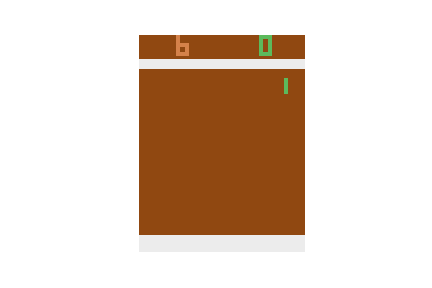
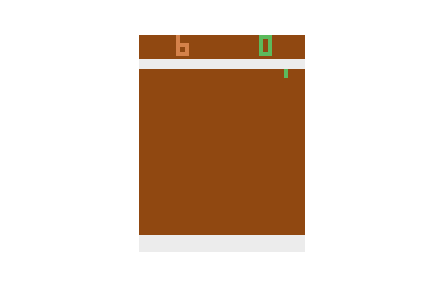
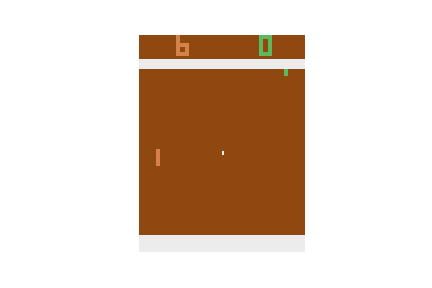
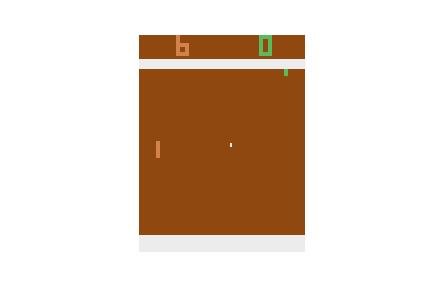
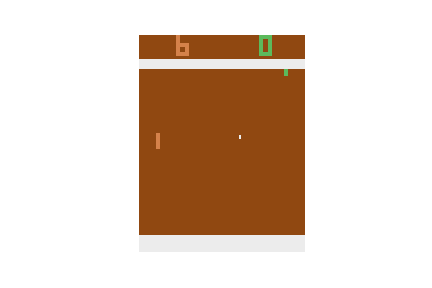
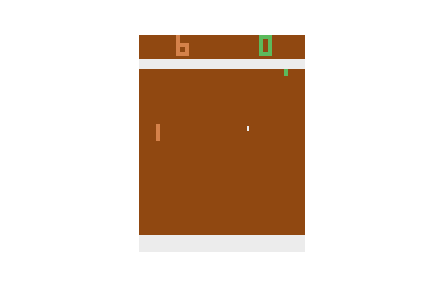
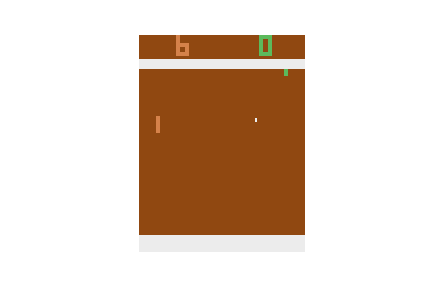
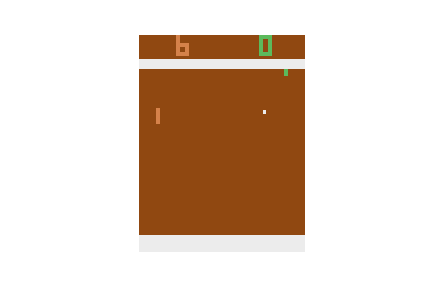
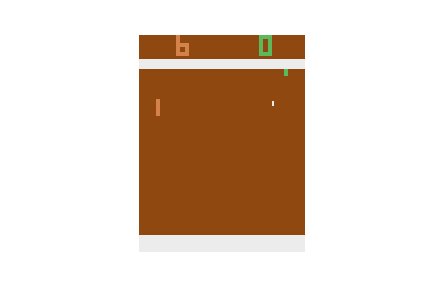
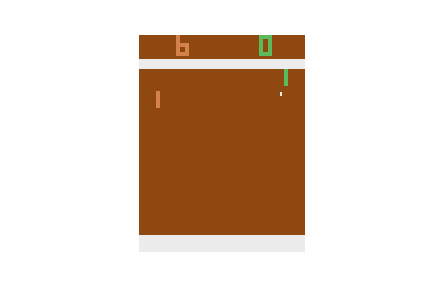
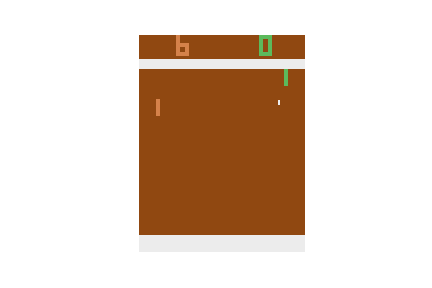
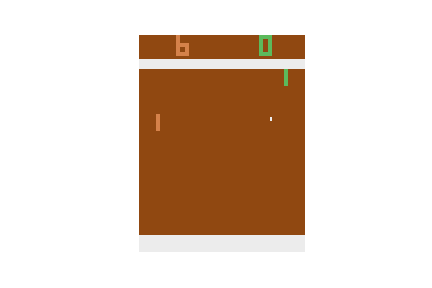
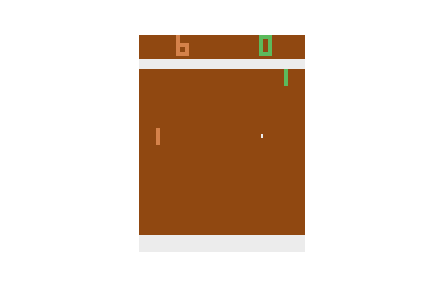
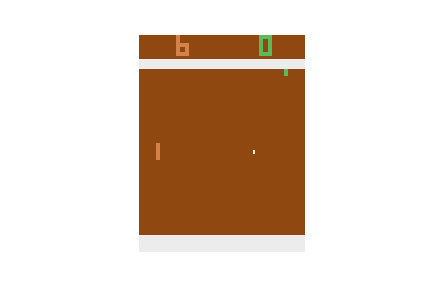
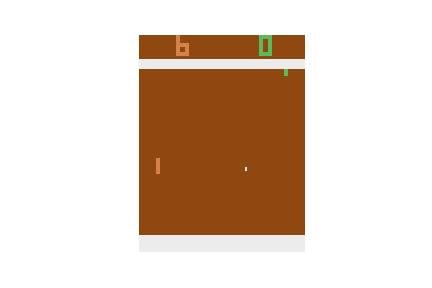
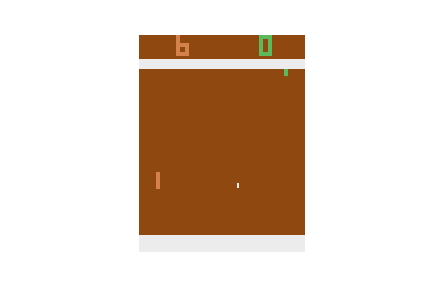
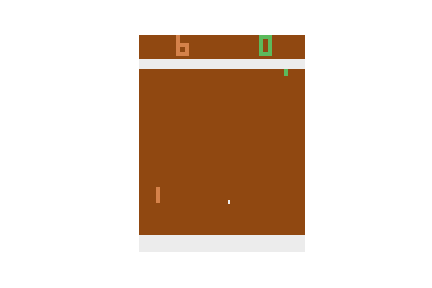
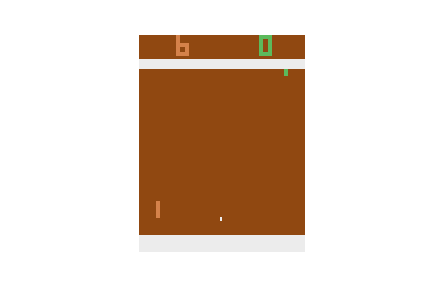
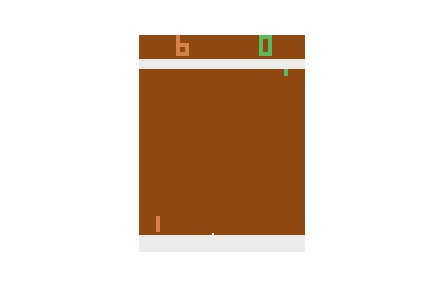
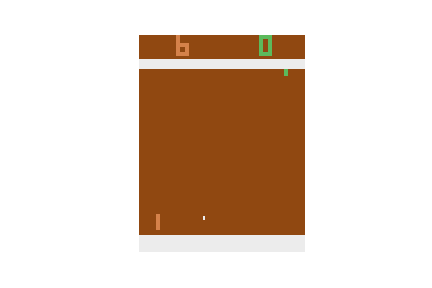
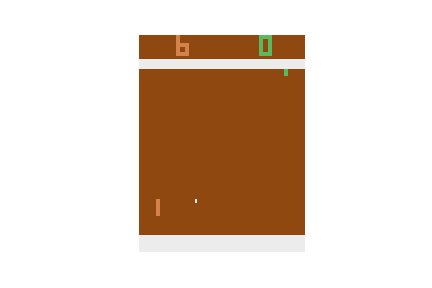
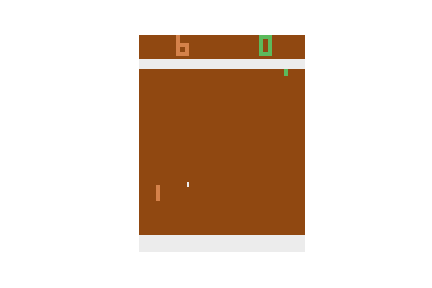
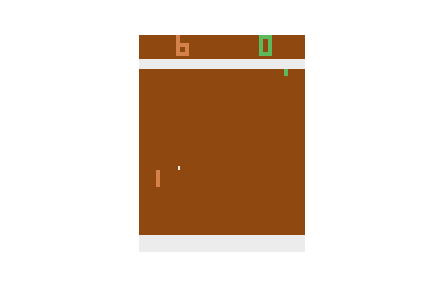
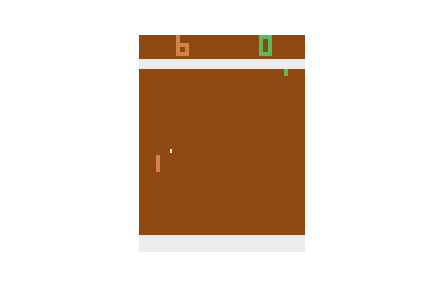
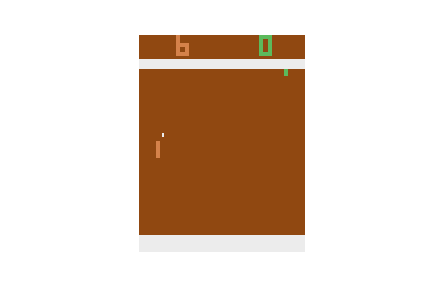
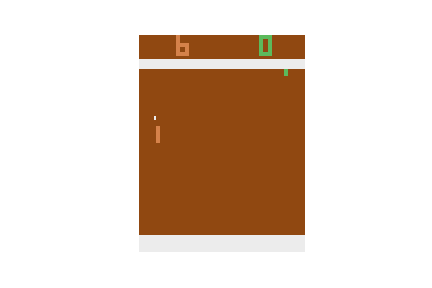
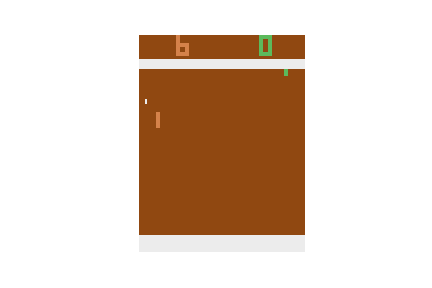
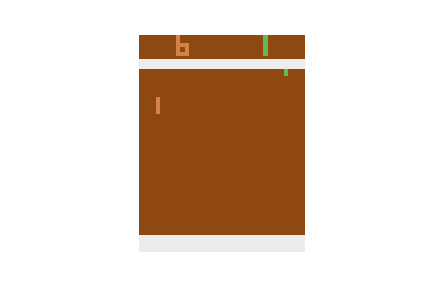
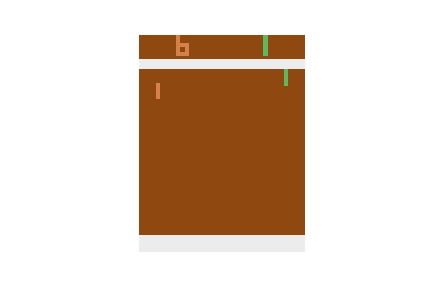
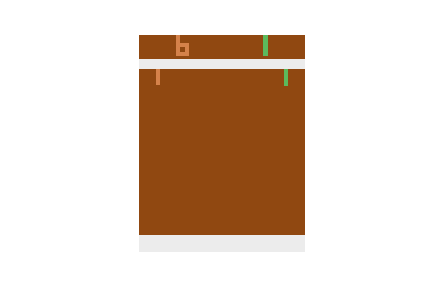
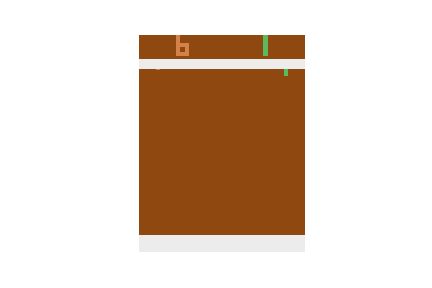
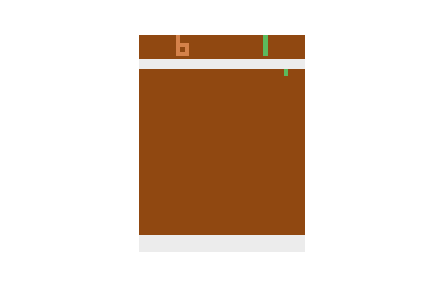
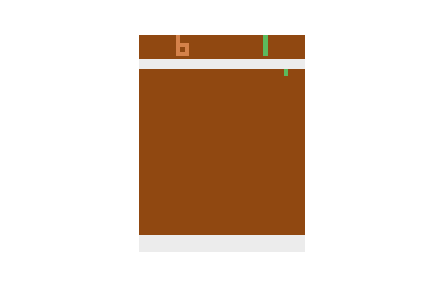
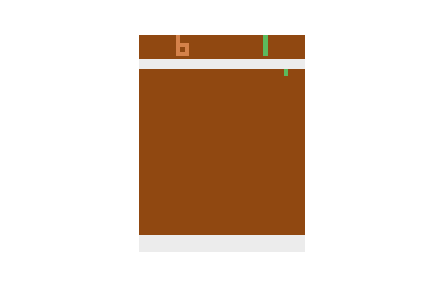
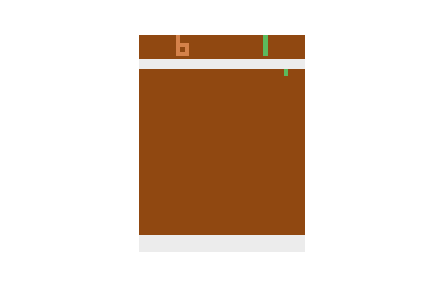
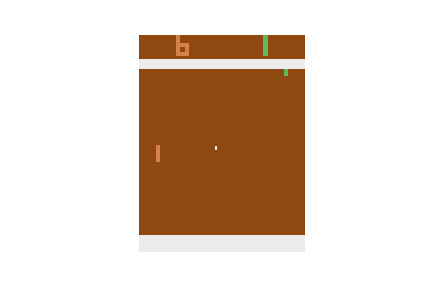
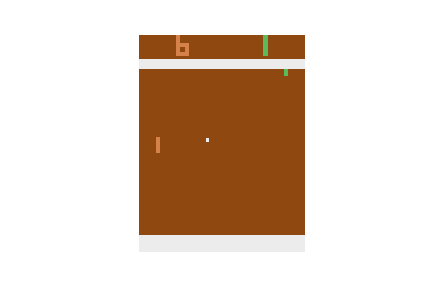
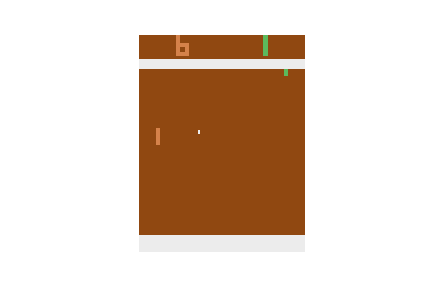
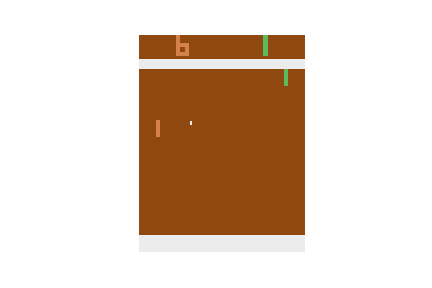
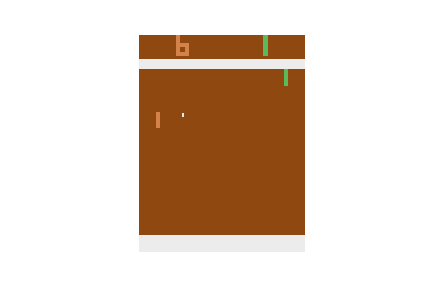
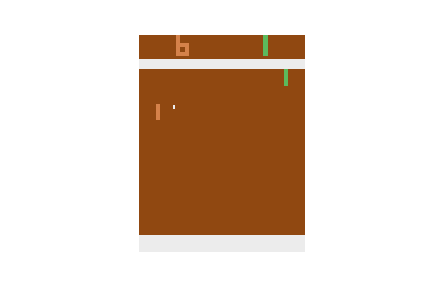
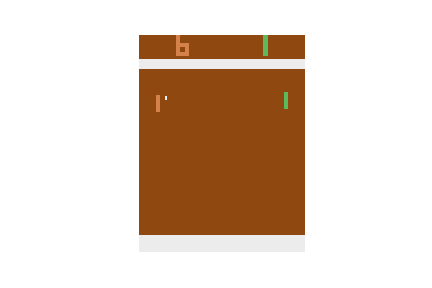
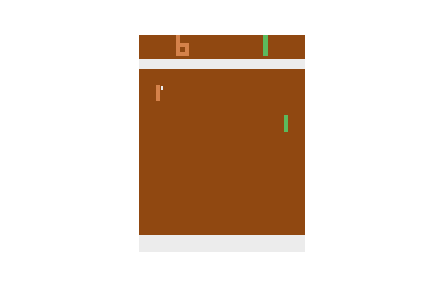

In [5]:
pong_utils.play(env, policy, time=200) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(what I call scalar function is the same as policy_loss up to a negative sign)

### PPO
Later on, you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

In [5]:
def clipped_surrogate(policy, old_probs, states, actions, rewards,
                      discount = 0.995, epsilon=0.1, beta=0.01):

    ########
    ## 
    ## WRITE YOUR OWN CODE HERE
    ##
    ########
    
    actions = torch.tensor(actions, dtype=torch.int8, device=device)

    # convert states to policy (or probability)
    new_probs = pong_utils.states_to_prob(policy, states)
    new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0-new_probs)

    # include a regularization term
    # this steers new_policy towards 0.5
    # prevents policy to become exactly 0 or 1 helps exploration
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    return torch.mean(beta*entropy)


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [7]:
import pdb

In [8]:
from parallelEnv import parallelEnv
import numpy as np
# keep track of how long training takes
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 500

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()


envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
epsilon = 0.1
beta = .01
tmax = 320
SGD_epoch = 4

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)


    # gradient ascent step
    for _ in range(SGD_epoch):
        
        # uncomment to utilize your own clipped function!
        # L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)

        L = -pong_utils.clipped_surrogate(policy, old_probs, states, actions, rewards,
                                          epsilon=epsilon, beta=beta)
#         pdb.set_trace()
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        del L
    
    # the clipping parameter reduces as time goes on
    epsilon*=.999
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()

> <ipython-input-8-0366a8de8536>(46)<module>()
-> optimizer.zero_grad()
(Pdb) L
tensor(-0.0069, grad_fn=<NegBackward>)
(Pdb) old_probs
[array([0.49704957, 0.49720052, 0.50286305, 0.49714205, 0.50295043,
       0.5027995 , 0.4971822 , 0.49720052], dtype=float32), array([0.4971747 , 0.50295246, 0.50286305, 0.5028938 , 0.49708444,
       0.4971747 , 0.49712095, 0.49704754], dtype=float32), array([0.5027673 , 0.49720475, 0.49719203, 0.50275624, 0.50285196,
       0.50277805, 0.50285345, 0.4972011 ], dtype=float32), array([0.49746835, 0.5026049 , 0.4975079 , 0.4974911 , 0.50254464,
       0.49752373, 0.4974554 , 0.50249696], dtype=float32), array([0.49728504, 0.5027376 , 0.4972617 , 0.49730858, 0.50268286,
       0.49725652, 0.50283766, 0.49732313], dtype=float32), array([0.49717766, 0.4972109 , 0.50282085, 0.4971661 , 0.49717268,
       0.49713033, 0.49711743, 0.5028355 ], dtype=float32), array([0.49716717, 0.4971664 , 0.49716717, 0.4970683 , 0.49719232,
       0.50280136, 0.50293666, 0.50

(Pdb) old_probs[1
*** SyntaxError: unexpected EOF while parsing
(Pdb) old_probs[1]
array([0.4971747 , 0.50295246, 0.50286305, 0.5028938 , 0.49708444,
       0.4971747 , 0.49712095, 0.49704754], dtype=float32)
(Pdb) states[1]
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          

BdbQuit: 

In [7]:
pong_utils.play(env, policy, time=200) 

AttributeError: 'HTMLWriter' object has no attribute '_temp_names'

In [6]:
# save your policy!
torch.save(policy, 'PPO.policy')

# load policy if needed
# policy = torch.load('PPO.policy')

# try and test out the solution 
# make sure GPU is enabled, otherwise loading will fail
# (the PPO verion can win more often than not)!
#
# policy_solution = torch.load('PPO_solution.policy')
# pong_utils.play(env, policy_solution, time=2000) 

In [36]:
!pip freeze

absl-py==0.9.0
astor==0.8.1
atari-py==0.2.6
atomicwrites==1.4.0
attrs==19.3.0
backcall==0.1.0
bleach==1.5.0
box2d-py==2.3.8
certifi==2020.4.5.1
cffi==1.14.0
cloudpickle==1.3.0
colorama==0.4.3
cycler==0.10.0
Cython==0.29.19
decorator==4.4.2
defusedxml==0.6.0
docopt==0.6.2
entrypoints==0.3
future==0.18.2
gast==0.3.3
glfw==1.11.1
google-pasta==0.2.0
grpcio==1.11.0
gym==0.17.2
h5py==2.10.0
html5lib==0.9999999
imageio==2.8.0
importlib-metadata==1.6.0
ipykernel==5.3.0
ipython==7.14.0
ipython-genutils==0.2.0
ipywidgets==7.5.1
jedi==0.17.0
Jinja2==2.11.2
JSAnimation==0.1
jsonschema==3.2.0
jupyter==1.0.0
jupyter-client==6.1.3
jupyter-console==6.1.0
jupyter-core==4.6.3
Keras-Applications==1.0.8
Keras-Preprocessing==1.1.2
kiwisolver==1.2.0
lockfile==0.12.2
Markdown==3.2.2
MarkupSafe==1.1.1
matplotlib==3.2.1
mistune==0.8.4
more-itertools==8.3.0
nbconvert==5.6.1
nbformat==5.0.6
notebook==6.0.3
numpy==1.18.4
opencv-python==4.2.0.34
packaging==20.4
pandas==1.0.4
pandocfilters==1.4.2
parso==0.7.0
pick

Werkzeug==1.0.1
widgetsnbextension==3.5.1
wincertstore==0.2
wrapt==1.12.1
zipp==3.1.0
